In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import gc, sys, os, timeit

In [4]:
UNIT_TIME = 91 # 一個購物週期3個月
UNIT_CNT = 4
UNIT_RECENT_COUNT_THREDSHOLD = 10

In [5]:
def parallel_apply(df, func, *args, **kwarg):
    ddf = dd.from_pandas(df, npartitions=CPU)
    res = ddf.map_partitions(lambda df: df.apply(lambda r: func(r, *args, **kwarg), axis = 1)).compute(get=get)
    gc.collect()
    return res

In [6]:
def time(worker):
    tick = timeit.default_timer()
    ret = worker()
    tock = timeit.default_timer()
    eclipse = tock-tick
    print('In %r:\n Spent %f sec'%(worker, eclipse))
    return eclipse, ret

## Loading...

In [7]:
df_member = pd.read_csv('../Member.csv')
df_ecoupon = pd.read_csv('../ECoupon.csv')
df_promotion = pd.read_csv('../PromotionOrders.csv')
df_main = pd.read_csv('../Orders.csv')


D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_member['MinOrderDate'].value_counts()

2016-11-11    2462
2016-07-08    2008
2016-11-13    1987
2016-09-28    1852
2016-09-27    1809
2016-04-10    1805
2016-07-09    1624
2016-03-20    1604
2016-03-06    1596
2016-11-12    1579
2016-07-10    1561
2016-07-06    1476
2016-07-07    1445
2015-10-12    1432
2017-11-11    1428
2016-11-14    1371
2016-03-19    1365
2017-11-12    1365
2016-03-13    1363
2016-07-14    1342
2016-03-16    1337
2016-04-09    1333
2016-11-10    1320
2016-03-07    1308
2016-07-15    1250
2016-04-02    1248
2016-04-21    1237
2015-12-06    1237
2016-07-11    1232
2016-03-17    1228
              ... 
2015-05-20      74
2017-01-24      74
2015-06-03      74
2018-02-16      73
2018-02-10      73
2015-05-22      70
2015-06-09      67
2015-05-29      63
2015-05-28      58
2018-02-14      58
2018-02-15      47
2015-06-02      42
2018-02-11      42
2015-05-26      39
2018-02-12      38
2015-05-27      33
2015-05-16      27
2015-05-10      25
2015-05-09      24
2015-05-17      22
2015-05-11      20
2015-05-13  

## 抓出N季的資料

In [9]:
df_main['Date'] = pd.to_datetime(df_main['DateId'].astype(str), format='%Y%m%d')

In [10]:
t_begin = df_main['Date'].min()
t_range = pd.Timedelta(120, unit='d')
print(t_begin)

2015-05-06 00:00:00


In [11]:
df_main.drop(labels='DateId', inplace=True, axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId                        object
DeliverTypeDef      

In [12]:
df_mains = {}
SEASON_CNT = 2
for i in range(SEASON_CNT):
    df_mains[i] = \
        df_main[df_main['Date'] < t_begin + t_range * (i + 1)]\
        [df_main['Date'] >= t_begin + t_range * (i)]


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


## Merge Data

In [13]:
for k in df_mains:
    df_mains[k] = df_mains[k].merge(df_ecoupon, on='ECouponId', how='left')
    df_mains[k] = df_mains[k].merge(df_promotion, on='SalesOrderSlaveId', how='left')
    gc.collect()

# 顧客分群 
## 由一季內的單次平均購買 vs 購買次數 進行客群劃分 
   - 分成五群 
       - 流失的客戶 0 vs 0
       

**統計單次消費總額**

In [14]:
main_by_baskets = {}
for k in df_mains:
    main_by_baskets[k] = df_mains[k]\
        .groupby(by=['OrderGroupCode','MemberId'], as_index=False)\
            ['SalesOrderSlaveTotalPayment']\
        .sum()
    print(main_by_baskets[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41425 entries, 0 to 41424
Data columns (total 3 columns):
OrderGroupCode                 41425 non-null object
MemberId                       41425 non-null int64
SalesOrderSlaveTotalPayment    41425 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 118771 entries, 0 to 118770
Data columns (total 3 columns):
OrderGroupCode                 118771 non-null object
MemberId                       118771 non-null int64
SalesOrderSlaveTotalPayment    118771 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ MB
None


### 計算每位會員平均單次消費額
- 用於計算客戶的季度總消費額

In [15]:
member_avgs = {}
def rename_col_to(name, old, new):
    if name == old:
        return new
    else:
        return name

for k in main_by_baskets:
    member_avgs[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('mean')
    member_avgs[k].rename(columns = lambda r: rename_col_to(r, 'SalesOrderSlaveTotalPayment', 'RecentAveragePurchase'), inplace=True)
    print(member_avgs[k].head())

   MemberId  RecentAveragePurchase
0      1329             359.500000
1      1372             125.000000
2      1373             448.000000
3      1423             373.000000
4      1469             543.428571
   MemberId  RecentAveragePurchase
0      1329                  199.0
1      1334                  415.0
2      1391                  593.0
3      1448                  977.0
4      1469                  688.0


**統計客戶的季度總消費額**

In [16]:
member_purchase_cnts = {}
for k in main_by_baskets:
    member_purchase_cnts[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('count')
    print(member_purchase_cnts[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31790 entries, 0 to 31789
Data columns (total 3 columns):
MemberId                       31790 non-null int64
OrderGroupCode                 31790 non-null int64
SalesOrderSlaveTotalPayment    31790 non-null int64
dtypes: int64(3)
memory usage: 993.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80380 entries, 0 to 80379
Data columns (total 3 columns):
MemberId                       80380 non-null int64
OrderGroupCode                 80380 non-null int64
SalesOrderSlaveTotalPayment    80380 non-null int64
dtypes: int64(3)
memory usage: 2.5 MB
None


In [17]:
member_purchase_medians = {}
member_purchase_averages = {}
for k in member_purchase_cnts:
    member_avgs[k]['RecentCount'] = member_purchase_cnts[k]['OrderGroupCode']
    member_avgs[k]['RecentTotal'] = member_avgs[k]['RecentCount'] * member_avgs[k]['RecentAveragePurchase']
    member_purchase_medians[k] = member_avgs[k]['RecentAveragePurchase'].median()
    member_purchase_averages[k] = member_avgs[k]['RecentAveragePurchase'].mean()
    print(member_avgs[k].head())
    print(member_purchase_medians[k])

   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1329             359.500000            2        719.0
1      1372             125.000000            2        250.0
2      1373             448.000000            1        448.0
3      1423             373.000000            1        373.0
4      1469             543.428571            7       3804.0
647.0
   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1329                  199.0            1        199.0
1      1334                  415.0            2        830.0
2      1391                  593.0            1        593.0
3      1448                  977.0            3       2931.0
4      1469                  688.0            5       3440.0
700.6666666666666


**印出各購買次數的會員平均單次購買金額的落點**

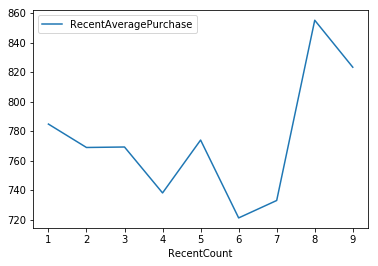

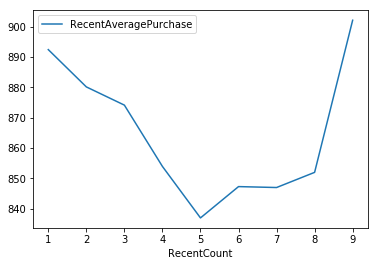

In [18]:
for k in member_avgs:
    tmp0 = member_avgs[k]\
        .groupby(by=['RecentCount'], as_index=False)\
            ['RecentAveragePurchase']\
        .mean()
    tmp0[tmp0['RecentCount'] < UNIT_RECENT_COUNT_THREDSHOLD]\
        .plot.line(x='RecentCount', y='RecentAveragePurchase')
    plt.show()
    gc.collect()
    

## 把各顧客分群並標上標記

In [19]:
RecentCount_threshold = 2

In [20]:
df_members = {}
for k in member_avgs:
    df_members[k] = df_member.merge(member_avgs[k], how='left')
    #print(df_members[k].info())
    #print(df_members[k].head())

In [21]:
df_members[0][~np.isnan(df_members[0]['RecentAveragePurchase'])]

,MemberId,Birthday,GenderTypeDef,RegisterSourceTypeDef,RegisterDateTime,MinOrderDate,OpenCardPresent,LastBirthdayPresentYear,IsInBlackList,RecentAveragePurchase,RecentCount,RecentTotal
8865,1383683,NaN,NaN,Web,2015-08-28 10:44:24.643,2015-08-28,0,0,NaN,399.000000,1.0,399.0
8894,1630818,1980-07-01,Female,Web,2015-08-21 22:20:45.473,2015-08-21,1838,2017,NaN,874.000000,1.0,874.0
8966,1302389,1986-09-20,Female,Web,2015-07-30 22:40:51.403,2015-08-01,318,2017,NaN,1120.000000,1.0,1120.0
8970,1154303,1979-09-11,Female,Web,2015-08-13 22:51:22.167,2015-08-13,318,2017,NaN,647.000000,1.0,647.0
9189,527959,NaN,NaN,NaN,2015-07-14 16:38:07.957,2015-07-11,0,0,NaN,299.000000,2.0,598.0
9190,590713,NaN,NaN,NaN,2015-07-28 14:19:27.403,2015-07-15,0,0,NaN,420.000000,1.0,420.0
9194,1288496,NaN,NaN,NaN,2015-07-28 14:19:01.270,2015-07-23,0,0,NaN,799.000000,1.0,799.0
9195,1452829,NaN,NaN,NaN,2015-07-28 14:21:42.170,2015-07-17,0,0,NaN,573.500000,2.0,1147.0
9265,1382140,NaN,NaN,NaN,2015-07-14 16:38:27.753,2015-07-01,0,0,NaN,1454.000000,1.0,1454.0
9298,403262,1995-11-15,Female,Web,2015-08-29 15:40:47.670,2015-08-29,7693,0,NaN,497.000000,1.0,497.0


In [22]:
'''
from multiprocessing import cpu_count, Pool
def parallelize(df, task, cores = cpu_count()):
    data_split = np.array_split(df, cores)
    pool = Pool(cores)
    data = pd.concat(pool.map(task, data_split))
    pool.close()
    pool.join()
    return data
def parallelize_by_df(dfs, core, func, *args):
    pool = Pool(cores)
    arg = []
    for i in range(dfs.__len__()):
        arg.append(list())
        arg[i].append(dfs, *args)
    pool.map(func, arg)
    pool.start()
    pool.join()
    return data
'''

'\nfrom multiprocessing import cpu_count, Pool\ndef parallelize(df, task, cores = cpu_count()):\n    data_split = np.array_split(df, cores)\n    pool = Pool(cores)\n    data = pd.concat(pool.map(task, data_split))\n    pool.close()\n    pool.join()\n    return data\ndef parallelize_by_df(dfs, core, func, *args):\n    pool = Pool(cores)\n    arg = []\n    for i in range(dfs.__len__()):\n        arg.append(list())\n        arg[i].append(dfs, *args)\n    pool.map(func, arg)\n    pool.start()\n    pool.join()\n    return data\n'

In [23]:
def set_member_group(row, axis_th_x = RecentCount_threshold, axis_th_y = 0, axis_key_x = 'RecentCount', axis_key_y = 'RecentAveragePurchase'):
    value = 0
    if not np.isnan(row[axis_key_x]) and row[axis_key_x] < axis_th_x:
        if row[axis_key_y] < axis_th_y:
            value = 3
        else:
            value = 2
    elif not np.isnan(row[axis_key_x]):
        if row[axis_key_y] < axis_th_y:
            value = 4
        else:
            value = 1
    
    return value


for k in df_members:
    df_members[k]['MemberGroup'] = \
        df_members[k].apply(lambda r: set_member_group(r, RecentCount_threshold, member_purchase_medians[k]), axis = 1)
    #    parallel_apply(df_members[k], set_member_group, RecentCount_threshold, member_purchase_medians[k])
    

In [24]:
statistics = {}

In [25]:
for k in df_members:
    statistics[k] = pd.DataFrame()
    statistics[k]['MemberCount'] = df_members[k]\
        .groupby(by='MemberGroup')['MemberId']\
        .agg(['count'])['count']
    print(statistics[k])

             MemberCount
MemberGroup             
0                 827443
1                   3284
2                  12679
3                  12846
4                   2894
             MemberCount
MemberGroup             
0                 779247
1                  11835
2                  28211
3                  30009
4                   9844


In [26]:
for k in df_members:
    statistics[k]['TotalSales'] = df_members[k].groupby(by='MemberGroup')['RecentTotal'].agg(['sum'])['sum']
    print(statistics[k])

             MemberCount  TotalSales
MemberGroup                         
0                 827443         0.0
1                   3284   8855442.0
2                  12679  14724415.0
3                  12846   5323394.0
4                   2894   3232439.0
             MemberCount  TotalSales
MemberGroup                         
0                 779247         0.0
1                  11835  38197307.0
2                  28211  36966141.0
3                  30009  15079925.0
4                   9844  13952686.0


In [27]:
for k in df_members:
    statistics[k].index = ['潛水客', '高消熟客','低消熟客','低消新客','高消新客']
    print(statistics[k])

      MemberCount  TotalSales
潛水客        827443         0.0
高消熟客         3284   8855442.0
低消熟客        12679  14724415.0
低消新客        12846   5323394.0
高消新客         2894   3232439.0
      MemberCount  TotalSales
潛水客        779247         0.0
高消熟客        11835  38197307.0
低消熟客        28211  36966141.0
低消新客        30009  15079925.0
高消新客         9844  13952686.0


## 資料整合

- 製作subindex: 對每筆資料加一個序號 

In [28]:
MAX_CUMCOUNT_OF_PURCHASE = 5 #每位會員最多留存的資料筆數上限

In [29]:
for k in df_mains:
    df_mains[k]['CumCountOfPurchase'] = df_mains[k].groupby('MemberId').cumcount()
    df_mains[k] = df_mains[k][df_mains[k]['CumCountOfPurchase'] < MAX_CUMCOUNT_OF_PURCHASE]
df_mains[0]

,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,IsSalePageGift,...,SalesOrderSlavePromotionDiscountAllocatedQty,SalesOrderSlavePromotionDiscountRate,DiscountType,PromotionCondition_DiscountPrice,PromotionCondition_DiscountRate,PromotionCondition_TotalPrice,PromotionCondition_TotalQty,PromotionStartDateTime,PromotionEndDateTime,CumCountOfPurchase
0,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457777,1242871,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457778,1242880,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457779,1242880,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457780,1175574,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",Web,Mobile,SevenEleven,4457791,1194488,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",Web,Mobile,SevenEleven,4457792,1256479,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",Web,Mobile,SevenEleven,4457793,1256508,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
7,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",Web,Mobile,SevenEleven,4457794,1256548,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
8,1388127,b'q4P\xfd\xf2\x98\x13\xe0\x83\x06\x01\xea\x8du...,Web,Mobile,Family,4457847,1221909,True,False,False,...,1.0,0.0,任選優惠價,299.0,0.0,0.0,2.0,2015-06-02 17:00:00.000,2015-07-10 13:00:00.000,0
9,1388127,b'q4P\xfd\xf2\x98\x13\xe0\x83\x06\x01\xea\x8du...,Web,Mobile,Family,4457848,1221913,True,False,False,...,1.0,0.0,任選優惠價,299.0,0.0,0.0,2.0,2015-06-02 17:00:00.000,2015-07-10 13:00:00.000,1


** 清理df_main不必要的欄位 **

In [30]:
df_mains[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114027 entries, 0 to 167460
Data columns (total 48 columns):
MemberId                                        114027 non-null int64
OrderGroupCode                                  114027 non-null object
TrackSourceTypeDef                              114027 non-null object
TrackDeviceTypeDef                              114027 non-null object
PayProfileTypeDef                               114027 non-null object
SalesOrderSlaveId                               114027 non-null int64
SalePageId                                      114027 non-null int64
IsMajor                                         114027 non-null bool
IsGift                                          114027 non-null bool
IsSalePageGift                                  114027 non-null bool
Quantity                                        114027 non-null int64
UnitPrice                                       114027 non-null float64
PromotionDiscount                             

In [31]:
DISCARD_LABEL = [
    'District',
    'ZipCode',
    'OrderGroupCode',
    'StoreName',
    'StoreId',
    'SalePageId', # 新版資料集變成數字 無法用one-hot展開
    'SalesOrderReceiverId',
    'SalesOrderSlaveId',
    'SalesOrderSlaveDateTime',
    'ReturnGoodsDateId',
    'CauseDef',
    'ECouponId',
    'ECouponStartDateTime',
    'ECouponEndDateTime',
    'ECouponUsingStartDateTime',
    'ECouponUsingEndDateTime',
    'PromotionId',
    'PromotionStartDateTime',
    'PromotionEndDateTime'
]

In [32]:
for k in df_mains:
    df_mains[k].drop(labels=DISCARD_LABEL, inplace=True, axis=1, errors='ignore')

df_mains[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114027 entries, 0 to 167460
Data columns (total 29 columns):
MemberId                                        114027 non-null int64
TrackSourceTypeDef                              114027 non-null object
TrackDeviceTypeDef                              114027 non-null object
PayProfileTypeDef                               114027 non-null object
IsMajor                                         114027 non-null bool
IsGift                                          114027 non-null bool
IsSalePageGift                                  114027 non-null bool
Quantity                                        114027 non-null int64
UnitPrice                                       114027 non-null float64
PromotionDiscount                               114027 non-null float64
ECouponDiscount                                 114027 non-null float64
SalesOrderSlaveTotalPayment                     114027 non-null float64
City                                     

** 把字串轉成數字 **

In [33]:
for k in df_mains:
    df_mains[k] = pd.get_dummies(df_mains[0])
    gc.collect()


** 把表格平攤 **

In [34]:
df_main_pivot_tables = {}
for k in df_mains:
    df_main_pivot_tables[k] = pd.pivot_table(df_mains[k], index='MemberId', columns='CumCountOfPurchase',fill_value=0.0)
    df_main_pivot_tables[k].columns = [it[0] + str(it[1]) for it in df_main_pivot_tables[k].columns.tolist() if True]
    df_main_pivot_tables[k]['MemberId'] = df_main_pivot_tables[k].index
    df_main_pivot_tables[k].index = range(df_main_pivot_tables[k].shape[0])
    gc.collect()
df_main_pivot_tables[0]

,City_Hy 0,City_Hy 1,City_Hy 2,City_Hy 3,City_Hy 4,City_Kot0,City_Kot1,City_Kot2,City_Kot3,City_Kot4,...,TrackSourceTypeDef_iOSApp1,TrackSourceTypeDef_iOSApp2,TrackSourceTypeDef_iOSApp3,TrackSourceTypeDef_iOSApp4,UnitPrice0,UnitPrice1,UnitPrice2,UnitPrice3,UnitPrice4,MemberId
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,420,299,0,0,0,1329
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100,150,0,0,0,1372
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,250,199,199,0,0,1373
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100,173,0,0,0,1423
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,249,261,199,299,199,1469
5,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,199,180,199,395,199,1498
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,199,350,199,0,0,2723
7,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,299,220,220,0,0,2940
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,299,299,0,0,0,2943
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,249,399,0,0,0,3270


** 清理 df_member **

In [35]:
DISCARD_LABEL_MEMBER = [
    'RegisterDateTime',
    'MinOrderDate',
    'LastBirthdayPresentYear',
    'IsInBlackList',
    'MinOrderDate'
]

In [36]:
df_members[0].head()

,MemberId,Birthday,GenderTypeDef,RegisterSourceTypeDef,RegisterDateTime,MinOrderDate,OpenCardPresent,LastBirthdayPresentYear,IsInBlackList,RecentAveragePurchase,RecentCount,RecentTotal,MemberGroup
0,1587633,NaN,NaN,Web,2016-08-05 19:45:59.670,NaN,0,0,NaN,NaN,NaN,NaN,0
1,1587634,NaN,NaN,Web,2016-10-27 21:25:22.907,NaN,0,0,NaN,NaN,NaN,NaN,0
2,1587658,NaN,NaN,Web,2015-08-11 19:11:09.030,NaN,0,0,NaN,NaN,NaN,NaN,0
3,1587809,NaN,NaN,Web,2015-08-11 19:53:32.397,NaN,0,0,NaN,NaN,NaN,NaN,0
4,1587830,NaN,NaN,Web,2017-06-03 17:33:03.987,NaN,0,0,NaN,NaN,NaN,NaN,0


In [37]:
for k in df_members:
    df_members[k].drop(labels=DISCARD_LABEL_MEMBER, inplace=True, axis=1, errors='ignore')

##  (Bottleneck)

In [38]:
# 日期轉型
def to_datetime_safe(row, label, na = np.NaN):
    try:
        return pd.to_datetime(row[label], format='%Y-%m-%d')
    except Exception as e:
        sys.stderr.write('Invalid datetime string: %r\n'%(row[label]))
        return na

for k in df_members:
    df_members[k]['Birthday'] = \
        time(lambda: df_members[k].apply(lambda r: to_datetime_safe(r, 'Birthday'), axis=1))[1] 
    #    time(lambda: parallel_apply(df_members[k], to_datetime_safe, 'Birthday'))[1]
    #    df_members[k].apply(lambda r: to_datetime_safe(r, 'Birthday'), axis=1) [0] 72s, [1] 74s
df_members[0].info()

Invalid datetime string: '0001-08-16'
Invalid datetime string: '0008-01-05'
Invalid datetime string: '2539-07-15'


In <function <lambda> at 0x00000214C84D47B8>:
 Spent 84.239250 sec


Invalid datetime string: '0001-08-16'
Invalid datetime string: '0008-01-05'
Invalid datetime string: '2539-07-15'


In <function <lambda> at 0x00000214C84D47B8>:
 Spent 84.326004 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 859146 entries, 0 to 859145
Data columns (total 9 columns):
MemberId                 859146 non-null int64
Birthday                 237272 non-null datetime64[ns]
GenderTypeDef            237276 non-null object
RegisterSourceTypeDef    829143 non-null object
OpenCardPresent          859146 non-null int64
RecentAveragePurchase    31703 non-null float64
RecentCount              31703 non-null float64
RecentTotal              31703 non-null float64
MemberGroup              859146 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 105.5+ MB


In [39]:
for k in df_members:
    df_members[k] = pd.get_dummies(df_members[k])    

** 和df_member合併 **

In [40]:
#debug
def print_type(df):
    tp = df.dtypes
    for i in range(tp.__len__()):
        print('%s %s'%(df.columns[i], tp[i]))

In [41]:
for k in df_members:
    df_members[k] = df_members[k].merge(df_main_pivot_tables[k], on='MemberId', how='left')
    gc.collect()
df_members[0].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 859146 entries, 0 to 859145
Columns: 342 entries, MemberId to UnitPrice4
dtypes: datetime64[ns](1), float64(318), int64(3), object(15), uint8(5)
memory usage: 2.2+ GB


In [42]:
def replace_col_label(df, old_label, new_label):
    col = list(df.columns)
    for i in range(len(col)):
        if col[i] == old_label:
            col[i] = new_label
            df.columns = col
            return

for i in range(len(df_members)):
    if i == len(df_members) - 1:
        break
    df = df_members[i + 1].loc[:, ['MemberId', 'MemberGroup']]
    replace_col_label(df, 'MemberGroup', 'MemberGroupNext')
    print(df.shape)
    df_members[i] = df_members[i].merge(df, on='MemberId', how='left')
    df_members[i]['MemberGroupNext'].fillna(1, inplace=True)
    gc.collect()

#df_members[0].dtypes

(859146, 2)


## 訓練

In [43]:

# 該季取樣比例 (不能全部套用 記憶體會爆炸)
MOTHER_SAMPLE_COUNT = 100000
# test/sample比例
TEST_FRACTION = 0.25
df_tests_inactive = {}
df_tests_active = {}
#df_trains_inactive = {}
#df_trains_active = {}
accuracies_active = {}
accuracies_inactive = {}


test = pd.DataFrame()

def train(df):
    train, test = train_test_split(
        df, 
        test_size = TEST_FRACTION
    )

    print('season %i raw shape: %r'%(k, cache_df.shape))
    #debug
    train.drop(columns=['Birthday'], inplace=True)
    test.drop(columns=['Birthday'], inplace=True)
    # 篩掉該季沒出現的
    print('train original: %i'%(train.shape[0]))
    train = train[train['MemberGroup'] != 1]
    print('train new: %i'%(train.shape[0]))
    #drop na where MemberGroupNext has nan value
    ##cache_df = cache_df[np.isfinite(df['MemberGroupNext'])]
    # 保留 MemberGroupNext空值 視同潛水客戶w
    train['MemberGroupNext'].fillna(1, inplace=True)
    test['MemberGroupNext'].fillna(1, inplace=True)
    
    # impute NA
    imputer = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
    imputer = imputer.fit(train)
    train_ndarr = imputer.fit_transform(train.drop(
            labels=['MemberId', 'MemberGroupNext'], 
            axis = 1,
            errors='ignore'))
    test_ndarr = imputer.fit_transform(test.drop(
            labels=['MemberId', 'MemberGroupNext'], 
            axis = 1, 
            errors='ignore'))

    #train.fillna(0, inplace=True)
    #print(cache_df.dtypes)
    #enddebug
    print('season %i filtered shape: %r'%(k, train.shape))
    
    rfc = RandomForestClassifier(
        criterion='entropy',
        n_estimators=25, 
        class_weight='balanced'
    )
    rfc_model = rfc.fit(
        train_ndarr, 
        train['MemberGroupNext']
    )
    
    test['predicted'] = rfc_model.predict(
        test_ndarr
    )
    
    accuracy = test.loc[:,['predicted', 'MemberGroupNext']]\
        .apply(lambda r: r['predicted'] == r['MemberGroupNext'], axis =1)\
        .sum()/test.shape[0]
        
    print('in group %i:\test naccuracy: %f\n\n'%(k, accuracy))
    #print(test.loc[:, ['predicted', 'MemberGroupNext']])
    return accuracy, train, test
        
for k in df_members:
    if k >= len(df_members) - 1:
        break
    #debug
    # todo convert Timestamp to int64
    #enddebug
    try:
        df = df_members[k]\
            [(df_members[k]['MemberGroupNext'] > 0) | (df_members[k]['MemberGroup'] > 0)]
            
        cache_df = df.sample(n = MOTHER_SAMPLE_COUNT)
        (accuracies_active[k], _, df_tests_active[k]) = train(cache_df)
        gc.collect()
    
            
        df = df_members[k]\
            [~((df_members[k]['MemberGroupNext'] > 0) | (df_members[k]['MemberGroup'] > 0))]
            
        cache_df = df.sample(n = MOTHER_SAMPLE_COUNT)
        (accuracies_inactive[k], _, df_tests_inactive[k]) = train(cache_df)
        gc.collect()
        
    except Exception as e:
        sys.stdout.write('Error occurs at season %i\n'%k)
        raise e
    finally:
        gc.collect()
        

season 0 raw shape: (100000, 343)
train original: 75000


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train new: 72640


D:\andyl\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


season 0 filtered shape: (72640, 342)


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


in group 0:	est naccuracy: 0.245760


season 0 raw shape: (100000, 343)


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train original: 75000
train new: 75000


D:\andyl\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


season 0 filtered shape: (75000, 342)


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


in group 0:	est naccuracy: 1.000000




In [44]:
tt = 0
others = 0
ff = 0
pred_zero = 0
def decision(df_, test_, predict_):
    global tt, others, ff, pred_zero
    if not df_[predict_]:
        pred_zero += 1
    if not df_[test_] and not df_[predict_]:
        ff += 1
        return
    if df_[test_] == df_[predict_]:
        tt += 1
        return
    others += 1

test.apply(lambda r: decision(r, 'MemberGroupNext', 'predicted'), axis = 1)
print('Test Pred: Active')
print('Total: %i'%df_tests_active[0].shape[0])
print('0  ==  0: %f%%'%(ff/df_tests_active[0].shape[0] * 100))
print('n  ==  n: %f%%'%(tt/df_tests_active[0].shape[0] * 100))
print('   !=   : %f%%'%(others/df_tests_active[0].shape[0] * 100))
print('\npred == 0: %f%%'%(pred_zero/df_tests_active[0].shape[0] * 100))

print('\nTest Pred: Inactive')
print('Total: %i'%df_tests_inactive[0].shape[0])
print('0  ==  0: %f%%'%(ff/df_tests_inactive[0].shape[0] * 100))
print('n  ==  n: %f%%'%(tt/df_tests_inactive[0].shape[0] * 100))
print('   !=   : %f%%'%(others/df_tests_inactive[0].shape[0] * 100))
print('\npred == 0: %f%%'%(pred_zero/df_tests_inactive[0].shape[0] * 100))


tt = 0
others = 0
ff = 0
pred_zero = 0

Test Pred: Active
Total: 25000
0  ==  0: 0.000000%
n  ==  n: 0.000000%
   !=   : 0.000000%

pred == 0: 0.000000%

Test Pred: Inactive
Total: 25000
0  ==  0: 0.000000%
n  ==  n: 0.000000%
   !=   : 0.000000%

pred == 0: 0.000000%


** 此季回頭率**

In [45]:
group_ = [2,3,4,5]
for k in df_members:
    if k >= len(df_members) - 1:
        break
    print('In season %i:'%k)
    current = df_members[k]
    for j in group_:
        numerator = (current\
        [((current['MemberGroup']==j) & (~np.isnan(current['MemberGroup'])))]\
        [((current['MemberGroupNext']>1) & (~np.isnan(current['MemberGroupNext'])))]\
        .shape[0])
        denominator = (current\
        [((current['MemberGroup']==j) & (~np.isnan(current['MemberGroup'])))].shape[0])
        #print('%f %f'%(numerator, denominator))
        ret_rate = 0
        try:
            ret_rate = numerator/denominator
        except ZeroDivisionError as e:
            ret_rate = 0.0
        print('group %i: return: %i, all: %i, return rate %f%%'%(j, numerator, denominator, ret_rate * 100))
    numerator = (\
        current[((current['MemberGroup']) &\
            (~np.isnan(current['MemberGroup'])))]\
        [((current['MemberGroupNext']) &\
            (~np.isnan(current['MemberGroupNext'])))]\
        .shape[0])
    denominator = (current[((current['MemberGroup']) &\
                            (~np.isnan(current['MemberGroup'])))].shape[0])
    ret_rate = numerator/denominator
    print('group all: return: %i, all: %i, return rate %f%%'%(numerator, denominator, ret_rate * 100))

In season 0:


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


group 2: return: 2031, all: 12679, return rate 16.018613%
group 3: return: 2030, all: 12846, return rate 15.802584%
group 4: return: 885, all: 2894, return rate 30.580511%
group 5: return: 0, all: 0, return rate 0.000000%
group all: return: 2126, all: 16130, return rate 13.180409%


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
